In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [76]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

In [2]:
file = pd.read_csv(r'Dataset/Dataset_13.05.2020_11.18am_1.csv')
tweets = np.asarray(file['Tweet'].copy())
targets = np.asarray(file['Is_Unreliable'].copy())
tweet_embeddings = np.load(r'Dataset/Tweet_Embeddings_Word2Vec_13.05.2020_2.41pm_1.npy', allow_pickle=True)
print(tweet_embeddings.shape)
print(tweet_embeddings[0].shape)
X = list()
for tweet in tweet_embeddings:
    embeddings = np.mean(tweet, axis=0, dtype=np.float64)
    X.append(embeddings)
X = np.asarray(X)
print(X.shape)
print(X.dtype)

y = targets
print(y.shape)
print(y.dtype)

(560,)
(15, 300)
(560, 300)
float64
(560,)
int64


In [113]:
class AE(nn.Module):

    def __init__(self):
        super(AE, self).__init__()
        self.fc1 = nn.Linear(300, 200)  # 6*6 from image dimension
        self.fc2 = nn.Linear(200, 300)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return x

# net = AE()
# print(net)

In [124]:
def train_AE(model, X_train, y_train, X_test, y_test, epochs=100, to_print=False):
    # define the optimization
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    train_mse_list, test_1_mse_list, test_0_mse_list = list(), list(), list()
    # enumerate epochs
    for epoch in tqdm(range(epochs)):
        # clear the gradients
        optimizer.zero_grad()
        X_train = torch.from_numpy(X_train).float()
        X_test = torch.from_numpy(X_test).float()
        output = model(X_train)
        train_loss = criterion(output, X_train)
        train_loss.backward()
        optimizer.step()
        if epoch%10 == 0 and to_print:
            print("epoch : {}/{}, train_loss = {:.6f}".format(epoch + 1, epochs, train_loss))
        
        train_preds = model(X_train)
        X_train = X_train.numpy()
        train_preds = train_preds.detach().numpy()
        test_preds = model(X_test)
        X_test = X_test.numpy()
        test_preds = test_preds.detach().numpy()
        train_mse = np.mean(np.square(X_train, train_preds), axis=1)
        test_1_mse = np.mean(np.square(X_test[y_test == 1], test_preds[y_test == 1]), axis=1)
        test_0_mse = np.mean(np.square(X_test[y_test == 0], test_preds[y_test == 0]), axis=1)
        train_mse_list.append(train_mse), test_1_mse_list.append(test_1_mse), test_0_mse_list.append(test_0_mse)
        # print('Train:', train_mse, ' Test (1_class):', test_1_mse, ' Test (0_class):', test_0_mse)
        
    return model, (train_mse_list, test_1_mse_list, test_0_mse_list)

In [118]:
def predict_AE(model, X_train, X_test, threshold, above_thres_class=0):
    
    X_train = torch.from_numpy(X_train).float()
    X_test = torch.from_numpy(X_test).float()
    train_out = model(X_train)
    X_train = X_train.numpy()
    train_out = train_out.detach().numpy()
    test_out = model(X_test)
    X_test = X_test.numpy()
    test_out = test_out.detach().numpy()
    train_mse = np.mean(np.square(X_train, train_out), axis=1)
    test_mse = np.mean(np.square(X_test, test_out), axis=1)
    
    train_preds, test_preds = np.empty((train_mse.shape[0])), np.empty((test_mse.shape[0]))
    train_preds[train_mse > threshold] = above_thres_class
    train_preds[train_mse <= threshold] = (above_thres_class+1)%2
    test_preds[test_mse > threshold] = above_thres_class
    test_preds[test_mse <= threshold] = (above_thres_class+1)%2
        
    return (train_preds, test_preds)

 36%|███▌      | 18/50 [00:00<00:00, 83.36it/s]

epoch : 1/50, train_loss = 0.005197
epoch : 11/50, train_loss = 0.003251


 84%|████████▍ | 42/50 [00:00<00:00, 97.68it/s]

epoch : 21/50, train_loss = 0.003116
epoch : 31/50, train_loss = 0.003051
epoch : 41/50, train_loss = 0.002996


100%|██████████| 50/50 [00:00<00:00, 102.42it/s]


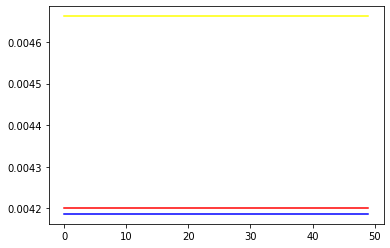

 30%|███       | 15/50 [00:00<00:00, 138.85it/s]

Train:  0.6290322580645161 0.7722772277227723 1.0 0.6290322580645161
Test :  0.6256684491978609 0.46153846153846156 0.3614457831325301 0.6382978723404256
epoch : 1/50, train_loss = 0.005454
epoch : 11/50, train_loss = 0.003321
epoch : 21/50, train_loss = 0.003139


 78%|███████▊  | 39/50 [00:00<00:00, 90.86it/s] 

epoch : 31/50, train_loss = 0.003048
epoch : 41/50, train_loss = 0.002996


100%|██████████| 50/50 [00:00<00:00, 89.29it/s]


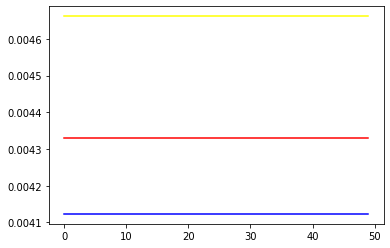

 32%|███▏      | 16/50 [00:00<00:00, 152.73it/s]

Train:  0.5561497326203209 0.7147766323024055 1.0 0.5561497326203209
Test :  0.6675603217158177 0.4655172413793104 0.38848920863309355 0.5806451612903226
epoch : 1/50, train_loss = 0.005099
epoch : 11/50, train_loss = 0.003188
epoch : 21/50, train_loss = 0.003034


100%|██████████| 50/50 [00:00<00:00, 126.74it/s]


epoch : 31/50, train_loss = 0.002926
epoch : 41/50, train_loss = 0.002861


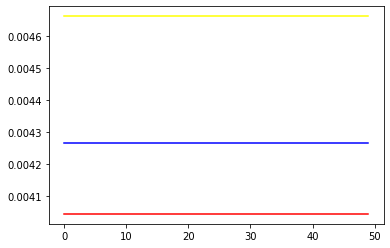

Train:  0.7647058823529411 0.8666666666666666 1.0 0.7647058823529411
Test :  0.546916890080429 0.4600638977635782 0.32727272727272727 0.7741935483870968

Train:  0.649962624345926 0.7845735088972815 1.0 0.649962624345926
Test :  0.6133818869980359 0.46237320022711675 0.35906923967945037 0.664378860672615


In [133]:
# Autoencoder on class=1 as training data

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

a_score, f_score, p_score, r_score, roc_score = list(), list(), list(), list(), list()
t_a_score, t_f_score, t_p_score, t_r_score, t_roc_score = list(), list(), list(), list(), list()

for train_index, test_index in kfold.split(X[y == 1], y[y == 1]):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    X_train, y_train = X[y == 1][train_index], y[y == 1][train_index]
    X_test, y_test = np.concatenate((X[y == 1][test_index], X[y == 0])), np.concatenate((y[y == 1][test_index], y[y == 0]))

    model = AE().to(device)
    model, (train_mse_list, test_1_mse_list, test_0_mse_list) = train_AE(model, X_train, y_train, X_test, y_test, epochs=50, to_print=True)
    
    # train_mse_list, test_1_mse_list, test_0_mse_list = np.mean(np.asarray(train_mse_list), axis=1), np.mean(np.asarray(test_1_mse_list), axis=1), np.mean(np.asarray(test_0_mse_list), axis=1)
    plt.plot(np.arange(len(train_mse_list)), np.mean(np.asarray(train_mse_list), axis=1), label='train_mse_list', color='blue')
    plt.plot(np.arange(len(test_1_mse_list)), np.mean(np.asarray(test_1_mse_list), axis=1), label='test_1_mse_list', color='red')
    plt.plot(np.arange(len(test_0_mse_list)), np.mean(np.asarray(test_0_mse_list), axis=1), label='test_0_mse_list', color='yellow')
    plt.show()
    
    best_f = 0
    train_preds, preds = np.empty((X_train.shape[0])), np.empty((X_test.shape[0]))
    for th in np.arange(0.0010, 0.0090, 0.0001):
        (tr_preds, te_preds) = predict_AE(model, X_train, X_test, threshold=th, above_thres_class=0)
        if (f1_score(y_test, te_preds) > best_f):
            best_f = f1_score(y_test, te_preds)
            train_preds = tr_preds
            preds = te_preds
    
    t_a_score.append(accuracy_score(y_train, train_preds))
    t_f_score.append(f1_score(y_train, train_preds)), t_p_score.append(precision_score(y_train, train_preds)), t_r_score.append(recall_score(y_train, train_preds))
    a_score.append(accuracy_score(y_test, preds))
    f_score.append(f1_score(y_test, preds)), p_score.append(precision_score(y_test, preds)), r_score.append(recall_score(y_test, preds))
    print('Train: ', t_a_score[-1], t_f_score[-1], t_p_score[-1], t_r_score[-1])
    print('Test : ', a_score[-1], f_score[-1], p_score[-1], r_score[-1])
    
print('')
print('Train: ', sum(t_a_score)/len(t_a_score), sum(t_f_score)/len(t_f_score), sum(t_p_score)/len(t_p_score), sum(t_r_score)/len(t_r_score))
print('Test : ', sum(a_score)/len(a_score), sum(f_score)/len(f_score), sum(p_score)/len(p_score), sum(r_score)/len(r_score))

 54%|█████▍    | 27/50 [00:00<00:00, 124.08it/s]

epoch : 1/50, train_loss = 0.005525
epoch : 11/50, train_loss = 0.003830
epoch : 21/50, train_loss = 0.003626


100%|██████████| 50/50 [00:00<00:00, 138.60it/s]


epoch : 31/50, train_loss = 0.003505
epoch : 41/50, train_loss = 0.003434


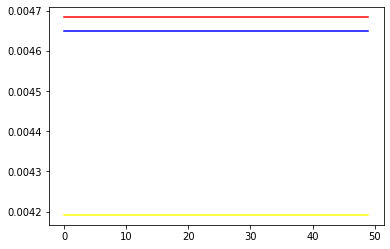

 34%|███▍      | 17/50 [00:00<00:00, 164.58it/s]

Train:  0.6774193548387096 0.8076923076923077 1.0 0.6774193548387096
Test :  0.606951871657754 0.4842105263157894 0.3612565445026178 0.7340425531914894
epoch : 1/50, train_loss = 0.005593
epoch : 11/50, train_loss = 0.003738
epoch : 21/50, train_loss = 0.003542


100%|██████████| 50/50 [00:00<00:00, 136.26it/s]

epoch : 31/50, train_loss = 0.003435
epoch : 41/50, train_loss = 0.003360


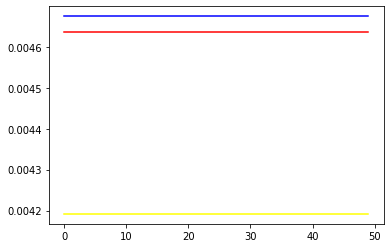

 34%|███▍      | 17/50 [00:00<00:00, 167.44it/s]

Train:  0.7005347593582888 0.8238993710691823 1.0 0.7005347593582888
Test :  0.5951742627345844 0.45878136200716857 0.34408602150537637 0.6881720430107527
epoch : 1/50, train_loss = 0.005583
epoch : 11/50, train_loss = 0.003683
epoch : 21/50, train_loss = 0.003494
epoch : 31/50, train_loss = 0.003398


100%|██████████| 50/50 [00:00<00:00, 147.91it/s]


epoch : 41/50, train_loss = 0.003318


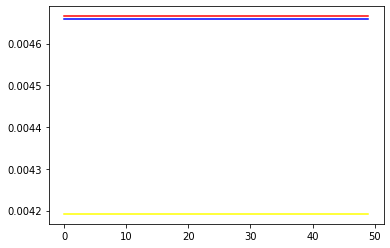

Train:  0.7112299465240641 0.8312499999999999 1.0 0.7112299465240641
Test :  0.5898123324396782 0.44765342960288806 0.33695652173913043 0.6666666666666666

Train:  0.6963946869070208 0.8209472262538299 1.0 0.6963946869070208
Test :  0.5973128222773388 0.46354843930861533 0.3474330292490415 0.6962937542896362


In [157]:
# Autoencoder on class=0 as training data (class=0 has been changed to class=1 for calculating f1_score, precision, etc.)

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

a_score, f_score, p_score, r_score, roc_score = list(), list(), list(), list(), list()
t_a_score, t_f_score, t_p_score, t_r_score, t_roc_score = list(), list(), list(), list(), list()

for train_index, test_index in kfold.split(X[y == 0], y[y == 0]):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    X_train, y_train = X[y == 0][train_index], y[y == 0][train_index]
    X_test, y_test = np.concatenate((X[y == 0][test_index], X[y == 1])), np.concatenate((y[y == 0][test_index], y[y == 1]))
    y_train[y_train == 1] = -1
    y_test[y_test == 1] = -1
    y_train[y_train == 0] = 1
    y_test[y_test == 0] = 1
    y_train[y_train == -1] = 0
    y_test[y_test == -1] = 0
    
    model = AE().to(device)
    model, (train_mse_list, test_1_mse_list, test_0_mse_list) = train_AE(model, X_train, y_train, X_test, y_test, epochs=50, to_print=True)
    
#     train_mse_list, test_1_mse_list, test_0_mse_list = np.mean(np.asarray(train_mse_list), axis=1), np.mean(np.asarray(test_1_mse_list), axis=1), np.mean(np.asarray(test_0_mse_list), axis=1)
    plt.plot(np.arange(len(train_mse_list)), np.mean(np.asarray(train_mse_list), axis=1), label='train_mse_list', color='blue')
    plt.plot(np.arange(len(test_1_mse_list)), np.mean(np.asarray(test_1_mse_list), axis=1), label='test_1_mse_list', color='red')
    plt.plot(np.arange(len(test_0_mse_list)), np.mean(np.asarray(test_0_mse_list), axis=1), label='test_0_mse_list', color='yellow')
    plt.show()
    
    best_f = 0
    train_preds, preds = np.empty((X_train.shape[0])), np.empty((X_test.shape[0]))
    for th in np.arange(0.0010, 0.0090, 0.0001):
        (tr_preds, te_preds) = predict_AE(model, X_train, X_test, threshold=th, above_thres_class=0)
        tr_preds[tr_preds == 1] = -1
        te_preds[te_preds == 1] = -1
        tr_preds[tr_preds == 0] = 1
        te_preds[te_preds == 0] = 1
        tr_preds[tr_preds == -1] = 0
        te_preds[te_preds == -1] = 0
        if (f1_score(y_test, te_preds) > best_f):
            best_f = f1_score(y_test, te_preds)
            train_preds = tr_preds
            preds = te_preds
    
    t_a_score.append(accuracy_score(y_train, train_preds))
    t_f_score.append(f1_score(y_train, train_preds)), t_p_score.append(precision_score(y_train, train_preds)), t_r_score.append(recall_score(y_train, train_preds))
    a_score.append(accuracy_score(y_test, preds))
    f_score.append(f1_score(y_test, preds)), p_score.append(precision_score(y_test, preds)), r_score.append(recall_score(y_test, preds))
    print('Train: ', t_a_score[-1], t_f_score[-1], t_p_score[-1], t_r_score[-1])
    print('Test : ', a_score[-1], f_score[-1], p_score[-1], r_score[-1])
    
print('')
print('Train: ', sum(t_a_score)/len(t_a_score), sum(t_f_score)/len(t_f_score), sum(t_p_score)/len(t_p_score), sum(t_r_score)/len(t_r_score))
print('Test : ', sum(a_score)/len(a_score), sum(f_score)/len(f_score), sum(p_score)/len(p_score), sum(r_score)/len(r_score))

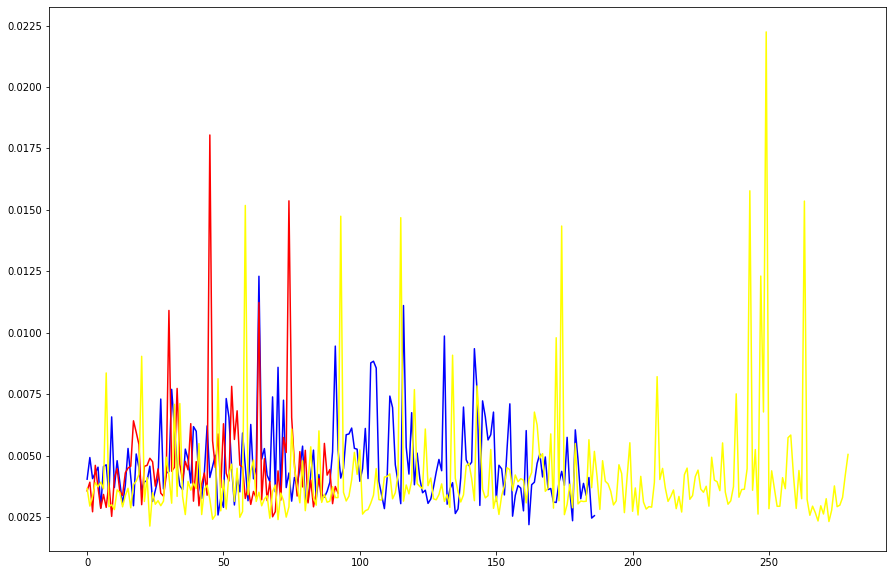

In [158]:
plt.figure(figsize=(15, 10))
plt.plot(np.arange(train_mse_list[-1].shape[0]), train_mse_list[0], label='train_mse_list', color='blue')
# plt.show()
plt.plot(np.arange(test_1_mse_list[-1].shape[0]), test_1_mse_list[0], label='test_1_mse_list', color='red')
# plt.show()
plt.plot(np.arange(test_0_mse_list[-1].shape[0]), test_0_mse_list[0], label='test_0_mse_list', color='yellow')
plt.show()